# A notebook for exploring how best to measure the change in Mtb

In [6]:
import napari
from macrohet import dataio, tile, tools, visualise
import numpy as np
import os

def view(img):
    return napari.Viewer().add_image(img)

from tqdm.auto import tqdm

import btrack
import dask.array as da

from skimage.transform import rescale, resize, downscale_local_mean
from natsort import natsorted
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
sns.set_palette("Spectral")

### Load all metadata

Both the image metadata and the assay layout metadata

In [3]:
%%time
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/PS0000/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!
CPU times: user 15.7 s, sys: 1.27 s, total: 16.9 s
Wall time: 16.9 s


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [4]:
%%time

metadata_path = os.path.join(base_dir, 'macrohet_images/PS0000/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!
CPU times: user 2.88 ms, sys: 3.64 ms, total: 6.51 ms
Wall time: 6.08 ms


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

# Iteratively load all tracks

and append to a track_dict dictionary

In [4]:
tracks_dict = dict()
### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    ### load tracks
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, 
                                                f'labels/macrohet_seg_model/{row,column}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks
            
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/06/19 03:38:53 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2023/06/19 03:38:53 PM] Loading tracks/obj_type_1
[INFO][2023/06/19 03:38:53 PM] Loading LBEP/obj_type_1
[INFO][2023/06/19 03:38:53 PM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2023/06/19 03:38:53 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5
[INFO][2023/06/19 03:38:53 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/19 03:38:53 PM] Loading tracks/obj_type_1
[INFO][2023/06/19 03:38:53 PM] Loading LBEP/obj_type_1
[INFO][2023/06/19 03:38:53 PM] Loading objects/obj_type_1 (41424, 5) (41424 filtered: None)
[INFO][2023/06/19 03:38:54 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5
[INFO][2023/06/19 03:38:54 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 6).h5...
[INFO][2023/06/19 03:38:54 PM] Loading tracks/obj_type_1
[INFO]

[INFO][2023/06/19 03:39:11 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5
[INFO][2023/06/19 03:39:11 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5...
[INFO][2023/06/19 03:39:11 PM] Loading tracks/obj_type_1
[INFO][2023/06/19 03:39:11 PM] Loading LBEP/obj_type_1
[INFO][2023/06/19 03:39:11 PM] Loading objects/obj_type_1 (45688, 5) (45688 filtered: None)
[INFO][2023/06/19 03:39:12 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5
[INFO][2023/06/19 03:39:12 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5...
[INFO][2023/06/19 03:39:12 PM] Loading tracks/obj_type_1
[INFO][2023/06/19 03:39:12 PM] Loading LBEP/obj_type_1
[INFO][2023/06/19 03:39:12 PM] Loading objects/obj_type_1 (45214, 5) (45214 filtered: None)
[INFO][2023/06/19 03:39:14 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5
[INFO][2023/06/19 03:39:14 PM] Opening HDF file: /mnt/DATA/macrohe

In [10]:
import glob, re, json
from natsort import natsorted
tracks_dict = dict()
for tracks_fn in tqdm(natsorted(glob.glob(os.path.join(base_dir, f'labels/macrohet_seg_model/*.h5')))):
    with btrack.io.HDF5FileHandler(tracks_fn, 'r') as hdf:
        tracks = hdf.tracks
        row, column = [int(x) for x in re.search(r'\((\d{1,2}),\s*(\d{1,2})\)\.h5$', tracks_fn).groups()]
    # load track score dict
    track_performance_dict_fn = os.path.join(base_dir, f'upstream_development/tracking/tracking_performance/{row},{column}/({row}, {column})_track_assessment.json')
    with open(track_performance_dict_fn, 'r') as json_file:
        # Load the JSON data into a Python dictionary
        track_performance_dict = json.load(json_file)
    # check the number of tracks you checked
    # filter for true tracks
    tracks = [t for t in tracks if str(t.ID) in track_performance_dict.keys() and track_performance_dict[str(t.ID)] == True and len(t) > 70]
    tracks_dict[row,column] = tracks

  0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/08/24 04:54:07 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2023/08/24 04:54:07 PM] Loading tracks/obj_type_1
[INFO][2023/08/24 04:54:07 PM] Loading LBEP/obj_type_1
[INFO][2023/08/24 04:54:07 PM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2023/08/24 04:54:12 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5
[INFO][2023/08/24 04:54:12 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/08/24 04:54:12 PM] Loading tracks/obj_type_1
[INFO][2023/08/24 04:54:12 PM] Loading LBEP/obj_type_1
[INFO][2023/08/24 04:54:12 PM] Loading objects/obj_type_1 (41424, 5) (41424 filtered: None)
[INFO][2023/08/24 04:54:12 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5
[INFO][2023/08/24 04:54:12 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 6).h5...
[INFO][2023/08/24 04:54:12 PM] Loading tracks/obj_type_1
[INFO]

# Compile all longer length tracks into dataframe

Add extra information such as the MSD of cells between frames

In [28]:
importlib.reload(tools)

<module 'macrohet.tools' from '/home/dayn/analysis/macrohet/macrohet/tools.py'>

In [29]:
df = tools.compile_multi_track_df(tracks_dict, assay_layout)

Processing Tracks:   0%|          | 0/24 [00:00<?, ?it/s]

In [12]:
%%time

df = pd.read_pickle(os.path.join(base_dir,'results/preliminary_sc_measures/sc_dfs/sc_df_40_interp.pkl'))
df

CPU times: user 152 ms, sys: 505 ms, total: 658 ms
Wall time: 2min 2s


,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,Technical replicate,dMtb
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.813310,0.000000,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232
1,1,725.449097,73.245003,3656.263447,369.154814,0.0,0.0,1.0,48727.0,362.852478,...,0.896474,17.860383,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232
2,2,723.088928,76.431496,3644.368198,385.214738,0.0,0.0,1.0,43484.0,363.515442,...,0.876911,3.965367,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232
3,3,726.009766,79.395073,3659.089219,400.151168,0.0,0.0,1.0,39113.0,360.448578,...,0.717504,4.161019,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232
4,4,728.209656,82.197769,3670.176665,414.276757,0.0,0.0,1.0,32644.0,362.289764,...,0.425791,3.562951,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701474,70,757.886719,44.412071,3819.749063,223.836839,1.0,1.0,1.0,71808.0,358.460327,...,0.923363,0.522451,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9,2.0,-0.000019
701475,71,760.801514,49.459522,3834.439629,249.275992,1.0,1.0,1.0,65328.0,358.026184,...,0.893735,5.828618,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9,2.0,-0.000019
701476,72,761.494873,50.097046,3837.934160,252.489111,1.0,1.0,1.0,66829.0,358.846039,...,0.888738,0.941904,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9,2.0,-0.000019
701477,73,759.911255,48.538654,3829.952725,244.634818,1.0,1.0,1.0,71877.0,358.451752,...,0.897926,2.221808,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9,2.0,-0.000019


### Renaming delta Mtb method of choice for ease of use

In [30]:
df['dMtb'] = df['delta Mtb max fold-change normalised max area']

# Style

### Adding technical replicate label 

In [47]:
assay_layout['Technical replicate'] = assay_layout.groupby(['Strain', 'Compound', 'Concentration', 'ConcentrationEC']).cumcount() + 1


In [48]:
assay_layout

Strain Compound Concentration ConcentrationEC  Technical replicate
3 4    RD1     CTRL             0             EC0                    1
  5     WT     CTRL             0             EC0                    1
  6     WT      PZA            60            EC50                    1
  7     WT      RIF           0.1            EC50                    1
  8     WT      INH          0.04            EC50                    1
  9     WT      BDQ          0.02            EC50                    1
4 4    RD1     CTRL             0             EC0                    2
  5     WT     CTRL             0             EC0                    2
  6     WT      PZA            60            EC50                    2
  7     WT      RIF           0.1            EC50                    2
  8     WT      INH          0.04            EC50                    2
  9     WT      BDQ          0.02            EC50                    2
5 4    RD1     CTRL             0             EC0                    3
  5     WT     CTRL             0             EC0                    3
  6     WT      PZA           400            EC99                    1
  7     WT      RIF             2            EC99                    1
  8     WT      INH             2            EC99                    1
  9     WT      BDQ           2.5            EC99                    1
6 4    RD1     CTRL             0             EC0                    4
  5     WT     CTRL             0             EC0                    4
  6     WT      PZA           400            EC99                    2
  7     WT      RIF             2            EC99                    2
  8     WT      INH             2            EC99                    2
  9     WT      BDQ           2.5            EC99                    2

In [46]:
df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb,Technical replicate 2
0,0,457.172943,8.791715,2304.151633,44.310242,1.0,1.0,0.0,20542.0,343.157196,...,0.929721,0.000000,RD1,CTRL,EC0,426,"(3, 4)",426.3.4,0.000586,1
1,1,459.138947,6.718642,2314.060291,33.861954,0.0,1.0,0.0,16683.0,344.687042,...,0.977788,2.857062,RD1,CTRL,EC0,426,"(3, 4)",426.3.4,0.000586,1
2,2,460.555237,10.785886,2321.198394,54.360864,0.0,1.0,0.0,18935.0,343.875061,...,0.733415,4.306780,RD1,CTRL,EC0,426,"(3, 4)",426.3.4,0.000586,1
3,3,455.878815,11.143067,2297.629226,56.161059,1.0,1.0,0.0,19937.0,345.565796,...,0.685354,4.690043,RD1,CTRL,EC0,426,"(3, 4)",426.3.4,0.000586,1
4,4,462.634186,14.050420,2331.676296,70.814116,1.0,1.0,0.0,21793.0,350.585083,...,0.727210,7.354437,RD1,CTRL,EC0,426,"(3, 4)",426.3.4,0.000586,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296992,70,628.562500,1099.782104,3167.955000,5542.901807,1.0,0.0,1.0,101991.0,377.731873,...,0.697015,5.203749,WT,BDQ,EC99,935,"(6, 9)",935.6.9,0.000030,2
296993,71,628.463684,1102.144409,3167.456968,5554.807822,1.0,0.0,1.0,100978.0,377.812103,...,0.690471,2.364371,WT,BDQ,EC99,935,"(6, 9)",935.6.9,0.000030,2
296994,72,628.672058,1101.594727,3168.507173,5552.037422,1.0,0.0,1.0,108397.0,376.812805,...,0.665902,0.587853,WT,BDQ,EC99,935,"(6, 9)",935.6.9,0.000030,2
296995,73,630.372803,1102.817749,3177.078926,5558.201455,1.0,0.0,1.0,107079.0,377.437073,...,0.647429,2.094831,WT,BDQ,EC99,935,"(6, 9)",935.6.9,0.000030,2


In [32]:
sns.set(font='Nimbus Sans', style = 'white')

### Old style

In [16]:
sns.color_palette('PiYG')

[(0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.9348712033833141, 0.6798154555940021, 0.8312187620146096),
 (0.9856978085351787, 0.9031910803537101, 0.9458669742406767),
 (0.9202614379084968, 0.9629373317954633, 0.8576701268742792),
 (0.6908881199538641, 0.8624375240292197, 0.4883506343713959),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

In [17]:
colors = ['#013220',#'#008B8B',#(0.204*0.8, 0.330*0.8, 0.706*0.8), 
          sns.color_palette('PiYG')[0], sns.color_palette('PiYG')[-1]]
colors

['#013220',
 (0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

### New style

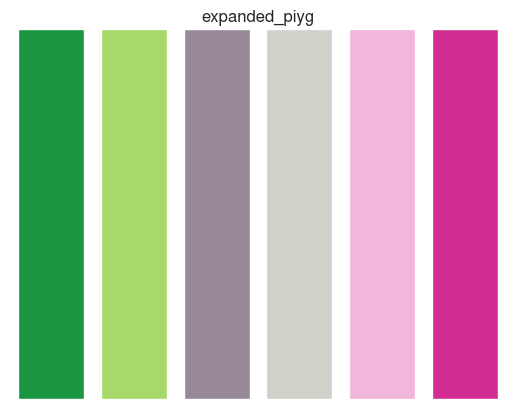

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']


In [38]:
# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors

sns.set_palette(expanded_piyg)

# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')
print(expanded_piyg)


# Output

In [33]:
output_dir = os.path.join(base_dir, 'results/interactive_plots/dMtb')
os.makedirs(output_dir, exist_ok = True)

# How many cells are truly permissive ie deltaMtb>0

#### What do the different distributions of deltaMtb look like?

In [34]:
df_delta_mtb = df.drop_duplicates(subset=['delta Mtb raw', 'delta Mtb max raw','delta Mtb max smooth', 'delta Mtb max fold-change'])
df_delta_mtb

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb,Technical replicate 2
0,0,457.172943,8.791715,2304.151633,44.310242,1.0,1.0,0.0,20542.0,343.157196,...,0.929721,0.0,RD1,CTRL,EC0,426,"(3, 4)",426.3.4,0.000586,1
74,0,663.630920,10.924337,3344.699839,55.058660,0.0,0.0,0.0,20098.0,353.067780,...,0.805467,0.0,RD1,CTRL,EC0,427,"(3, 4)",427.3.4,0.000544,1
149,0,725.798340,20.058319,3658.023633,101.093928,1.0,1.0,0.0,29683.0,362.856537,...,0.540146,0.0,RD1,CTRL,EC0,435,"(3, 4)",435.3.4,-0.000789,1
224,0,89.238220,86.176323,449.760630,434.328668,0.0,0.0,0.0,29980.0,368.084900,...,0.676988,0.0,RD1,CTRL,EC0,468,"(3, 4)",468.3.4,0.000000,1
299,0,331.759827,89.224770,1672.069526,449.692839,1.0,1.0,1.0,25356.0,400.908905,...,0.700553,0.0,RD1,CTRL,EC0,472,"(3, 4)",472.3.4,-0.000010,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296635,2,1090.928833,529.117737,5498.281318,2666.753394,0.0,0.0,0.0,13978.0,376.818298,...,0.883639,0.0,WT,BDQ,EC99,817,"(6, 9)",817.6.9,0.356070,2
296708,2,440.705811,626.353271,2221.157285,3156.820488,1.0,1.0,1.0,61767.0,398.949249,...,0.971427,0.0,WT,BDQ,EC99,814,"(6, 9)",814.6.9,0.000030,2
296781,2,1139.693848,723.973694,5744.056992,3648.827417,1.0,1.0,1.0,33122.0,410.231384,...,0.871169,0.0,WT,BDQ,EC99,740,"(6, 9)",740.6.9,-0.003271,2
296854,3,10.119422,1189.885742,51.001887,5997.024141,1.0,1.0,0.0,10593.0,354.040588,...,0.745716,0.0,WT,BDQ,EC99,865,"(6, 9)",865.6.9,-0.002747,2


In [131]:
df_delta_mtb

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb,Technical replicate
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.813310,0.0,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,0.095232,1
42,0,261.683105,4.945100,1318.882852,24.923306,0.0,0.0,0.0,6754.0,355.006958,...,0.913146,0.0,RD1,CTRL,EC0,424,"(3, 4)",424.3.4,-0.000112,1
89,0,349.589508,8.074520,1761.931121,40.695581,0.0,0.0,0.0,13672.0,344.202454,...,0.957093,0.0,RD1,CTRL,EC0,425,"(3, 4)",425.3.4,0.000000,1
152,0,457.172943,8.791715,2304.151633,44.310242,1.0,1.0,0.0,20542.0,343.157196,...,0.929721,0.0,RD1,CTRL,EC0,426,"(3, 4)",426.3.4,0.000586,1
226,0,663.630920,10.924337,3344.699839,55.058660,0.0,0.0,0.0,20098.0,353.067780,...,0.805467,0.0,RD1,CTRL,EC0,427,"(3, 4)",427.3.4,0.000544,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701271,33,660.136597,577.060730,3327.088447,2908.386079,0.0,0.0,0.0,47448.0,377.264587,...,0.952213,0.0,WT,BDQ,EC99,2297,"(6, 9)",2297.6.9,0.000032,2
701313,33,224.372467,131.369995,1130.837234,662.104775,1.0,1.0,1.0,98867.0,373.245178,...,0.885194,0.0,WT,BDQ,EC99,2292,"(6, 9)",2292.6.9,-0.000153,2
701355,33,1106.007935,1032.619019,5574.279990,5204.399854,0.0,0.0,1.0,53641.0,366.914032,...,0.950100,0.0,WT,BDQ,EC99,2286,"(6, 9)",2286.6.9,0.000089,2
701397,34,477.689026,538.676697,2407.552690,2714.930552,0.0,0.0,0.0,36503.0,356.196930,...,0.796381,0.0,WT,BDQ,EC99,2324,"(6, 9)",2324.6.9,0.000167,2


In [35]:
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, output_file, ColumnDataSource, output_notebook
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6
from bokeh.models import WheelZoomTool
from bokeh.plotting import save
from bokeh.models import Label
from bokeh.models import LogScale
from bokeh.models import NumeralTickFormatter

output_notebook()


Loading BokehJS ...

In [36]:
df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'})


,Strain,Compound,Concentration,count
0,RD1,CTRL,EC0,515
1,WT,BDQ,EC50,339
2,WT,BDQ,EC99,174
3,WT,CTRL,EC0,733
4,WT,INH,EC50,298
5,WT,INH,EC99,285
6,WT,PZA,EC50,259
7,WT,PZA,EC99,347
8,WT,RIF,EC50,320
9,WT,RIF,EC99,321


In [39]:
expanded_piyg_dict = {
                      'CTRL':expanded_piyg[0], 
                      'RD1':expanded_piyg[-1],
                      'BDQ':expanded_piyg[0], 
                      'INH':expanded_piyg[1], 
                      'PZA':expanded_piyg[4], 
                      'RIF':expanded_piyg[5]}

In [ ]:
df_delta_mtb

In [40]:
for index, row_ in df_delta_mtb.iterrows():
    cell_ID = row_['Cell ID']
    row, column = row_['Acquisition ID']
    online_fn = f'https://macrohet.s3.eu-west-2.amazonaws.com/{row},{column}/glimpse_{cell_ID}.{row}.{column}_t0.png'
    df_delta_mtb.at[index, 'glimpse_url'] = online_fn


# Creating scatter from one data source

Cannot currently link image URLs to segregated datasources...

In [41]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.layouts import column
from bokeh.layouts import gridplot
from bokeh.models import Range1d


output_notebook()

Loading BokehJS ...

In [ ]:
assay_layout

# KDE hist

# 3 plots showing diff conditions

In [45]:
from bokeh.layouts import gridplot
from scipy.stats import gaussian_kde

# Create the upper plot
p1 = figure(height=400, 
            width=450, 
            title='Histograms showing the distribution of \nthe change in intracellular Mtb (ΔMtb)', 
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p1.toolbar.active_scroll = p1.select_one(WheelZoomTool)
p1.x_range = Range1d(-0.4, 0.4)
# Customize y-axis ticker
p1.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p2 = figure(height=200, 
            width=450, 
            x_axis_label='ΔMtb \n(fold-change relative to area)',
            y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p1.x_range)

p2.yaxis.ticker = []  # Remove y-axis ticks
p2.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p2.toolbar.active_scroll = p2.select_one(WheelZoomTool)

# Create the hover tool
hover = HoverTool(
    tooltips=
    """ <div>
        <div style="position: relative; display: inline-block;">
            <img
                src="@glimpse_url_t0" height="120" alt="@glimpse_url_t0" width="120"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            >
            <div style="position: absolute; bottom: 5px; right: 5px; background-color: lightgrey; padding: 5px;">
                <span style="font-size: 12px; color: black;">t = 0</span>
            </div>
            </img>
        </div>
        <div style="position: relative; display: inline-block;">
            <img
                src="@glimpse_url_tn" height="120" alt="@glimpse_url_tn" width="120"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            >
            <div style="position: absolute; bottom: 5px; right: 5px; background-color: lightgrey; padding: 5px;">
                <span style="font-size: 12px; color: black;">t = final</span>
            </div>
            </img>
        </div>
        <div>
             <span style="font-size: 17px; font-weight: bold; color: black;">Cell ID: @cell_ID</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">ΔMtb: @x</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Strain: @strain</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Compound: @compound</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Concentration: @concentration</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Tech. replicate: @tech_rep</span>
         </div>
    </div>
""")

p2.add_tools(hover)  # Add the instance of HoverTool

outliers = list()
for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec50
    if condition['Concentration'] != 'EC50':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p1.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color=expanded_piyg_dict[compound], 
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p1.line(x='x', y='kde_values',
             source=source, 
             line_color=expanded_piyg_dict[compound], 
             line_width = 3, 
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df['Acquisition ID'].apply(lambda x: x[-1]),
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p2.scatter('x', 'y', 
               source=source,
               color=expanded_piyg_dict[compound], 
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )
    p2.y_range.start = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).min()-2  # Set the lower limit of the y-axis
    p2.y_range.end = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).max()+3

# Set the legend location for the upper plot
p1.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p1.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create the upper plot
p3 = figure(height=400, 
            width=450, 
#             title='Histogram showing the distribution of the change in intracellular Mtb (ΔMtb)', 
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p3.toolbar.active_scroll = p3.select_one(WheelZoomTool)
p3.x_range = Range1d(-0.4, 0.4)

# Customize y-axis ticker
p3.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p4 = figure(height=200, 
            width=450, 
            x_axis_label='ΔMtb \n(fold-change relative to area)',
            y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p3.x_range)

p4.yaxis.ticker = []  # Remove y-axis ticks
p4.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p4.toolbar.active_scroll = p4.select_one(WheelZoomTool)

p4.add_tools(hover)  # Add the instance of HoverTool (no need to repeat)


for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec99
    if condition['Concentration'] != 'EC99':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p3.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color=expanded_piyg_dict[compound], 
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p3.line(x='x', y='kde_values',
             source=source, 
             line_color=expanded_piyg_dict[compound], 
             line_width = 3,
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df['Acquisition ID'].apply(lambda x: x[-1]),
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p4.scatter('x', 'y', 
               source=source,
               color=expanded_piyg_dict[compound], 
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )
        
    p4.y_range.start = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).min()-2  # Set the lower limit of the y-axis
    p4.y_range.end = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).max()+3

# Set the legend location for the upper plot
p3.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p3.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create the upper plot
p5 = figure(height=400, 
            width=450, 
            title='Control experiments', 
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p5.toolbar.active_scroll = p5.select_one(WheelZoomTool)
p5.x_range = Range1d(-0.4, 0.4)

# Customize y-axis ticker
p5.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p6 = figure(height=200, 
            width=450, 
            x_axis_label='ΔMtb \n(fold-change relative to area)',
            y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p5.x_range)

p6.yaxis.ticker = []  # Remove y-axis ticks
p6.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p6.toolbar.active_scroll = p6.select_one(WheelZoomTool)

p6.add_tools(hover)  # Add the instance of HoverTool (no need to repeat)

for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec99
    if condition['Concentration'] != 'EC0':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p5.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1],
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p5.line(x='x', y='kde_values',
             source=source, 
             line_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1], 
             line_width = 1,
             line_dash = 'dashed',
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df['Acquisition ID'].apply(lambda x: x[-1]),
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p6.scatter('x', 'y', 
               source=source,
               fill_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1],
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )
    p6.y_range.start = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).min()-2  # Set the lower limit of the y-axis
    p6.y_range.end = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).max()+1

# Set the legend location for the upper plot
p5.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p5.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create a grid plot with both plots repeated on the right-hand side
p = gridplot([[p1, p3, p5], [p2, p4, p6]])

output_file(os.path.join(output_dir, "dMtb_kde_gt_survivors.html"),title="dMtb")

show(p)


KeyError: 'Technical replicate'

In [49]:
outlier_df['Acquisition ID'].apply(lambda x: x[-1]).min()

4

In [727]:
outliers = pd.concat(outliers, ignore_index=True)
outliers

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb,Technical replicate,glimpse_url,glimpse_url_t0,glimpse_url_tn
0,0,539.885864,99.211456,2721.024756,500.025740,0.0,0.0,1.0,24629.0,367.672302,...,BDQ,EC50,421,"(3, 9)",421.3.9,0.244142,1,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
1,0,1074.527832,811.853455,5415.620273,4091.741411,0.0,0.0,1.0,19622.0,369.415039,...,BDQ,EC50,113,"(3, 9)",113.3.9,1.114547,1,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
2,0,1097.321167,847.022522,5530.498682,4268.993511,0.0,0.0,1.0,10637.0,375.349060,...,BDQ,EC50,26,"(3, 9)",26.3.9,0.254726,1,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
3,0,1039.033447,916.104431,5236.728574,4617.166333,1.0,1.0,1.0,19872.0,389.052826,...,BDQ,EC50,63,"(3, 9)",63.3.9,0.154472,1,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
4,0,771.073486,1052.282593,3886.210371,5303.504268,0.0,0.0,1.0,28811.0,361.714722,...,BDQ,EC50,275,"(3, 9)",275.3.9,0.160494,1,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,4,757.554932,170.470444,3818.076855,859.171036,1.0,1.0,1.0,13940.0,388.782074,...,CTRL,EC0,1075,"(6, 5)",1075.6.5,0.276201,2,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
311,6,122.582176,206.176346,617.814168,1039.128783,0.0,0.0,1.0,14622.0,382.337433,...,CTRL,EC0,1216,"(6, 5)",1216.6.5,0.258478,2,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
312,7,818.922974,438.001740,4127.371787,2207.528767,0.0,0.0,1.0,31789.0,345.671936,...,CTRL,EC0,1314,"(6, 5)",1314.6.5,1.900590,2,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
313,16,333.640533,118.059662,1681.548289,595.020696,0.0,0.0,1.0,52010.0,366.959137,...,CTRL,EC0,1894,"(6, 5)",1894.6.5,1.283940,2,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
